# Surface Crack Images - LeNet5 model
This notebook contains the code training the LeNet5 model (without augmented data)

**Load packages/modules**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import time
import torch
import torchvision

from torchvision import datasets, transforms

print(f'Torch version: {torch .__version__}')

Torch version: 1.10.0+cu111


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid

%pip install torchsummary

from torchvision import models
from torchsummary import summary

**Load data into tensors first**<br>
Then concatenate the tensors with original and augmented data into one for ease of model training

In [4]:
# load data into tensors first
data_dir = '/content/drive/MyDrive/SJSU MSDA/Fall 2021/DATA 255/Project/Code/data/archive/original'
# aug_data_dir = '/content/drive/MyDrive/SJSU MSDA/Fall 2021/DATA 255/Project/Code/data/archive/augmented'
batch_size = 64 

transform = transforms.Compose([transforms.ToTensor()])

data = datasets.ImageFolder(data_dir, transform=transform)

dataloader = torch.utils.data.DataLoader(data, 
                                         batch_size=batch_size,
                                         shuffle=True, 
                                         pin_memory=True)

# aug_dataloader = torch.utils.data.DataLoader(aug_data,
#                                              batch_size=batch_size*9,  # multiply by 9 since augmented x9 images for each original
#                                              shuffle=True,
#                                              pin_memory=True)

# images, labels = next(iter(dataloader))
# aug_images, aug_labels = next(iter(aug_dataloader))

# print(f'Original images shape: {images.shape}')
# print(f'Augmented images shape: {aug_images.shape}')

In [ ]:
# generate and save test set
test_counter = 1
for i, data in enumerate(dataloader, 0):
    if i+1 > 500:
        if test_counter == 1:
            test_inputs, test_labels = data 
            test_counter += 1
        else:
            new_inputs, new_labels = data
            test_inputs = torch.concat((test_inputs, new_inputs), 0)
            test_labels = torch.concat((test_labels, new_labels), 0)
            test_counter += 1

        # print(f'Batch {i+1} for test set complete.')
    else:
        continue

# print(f'Saving test inputs {test_inputs.shape}, test labels {test_labels.shape}')

# save test set at the end of training
testset = [test_inputs, test_labels]
path = f"/content/drive/MyDrive/SJSU MSDA/Fall 2021/DATA 255/Project/Code/LeNet5_model_saves/00_tanh_lr0.001/lenet5_lr0.001_testset.pth"
torch.save(testset, path)

Check labels and images

images.shape: torch.Size([5, 3, 227, 227])
Labels: tensor([0, 1, 0, 0, 1])


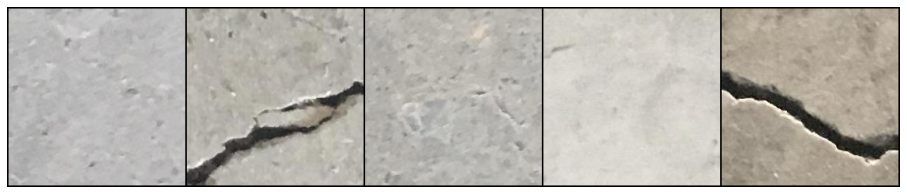

In [ ]:
# check labels in original images (using batch size=5 in dataloader)
'''
Label 0 = no surface crack
Label 1 = has surface crack
'''

print('images.shape:', images.shape)
plt.figure(figsize=(16,8))
plt.axis('off')
plt.imshow(make_grid(images, nrow=5).permute((1, 2, 0)))
    
print(f'Labels: {labels}')

aug_images.shape: torch.Size([5, 3, 227, 227])
Labels: tensor([0, 1, 0, 1, 0])


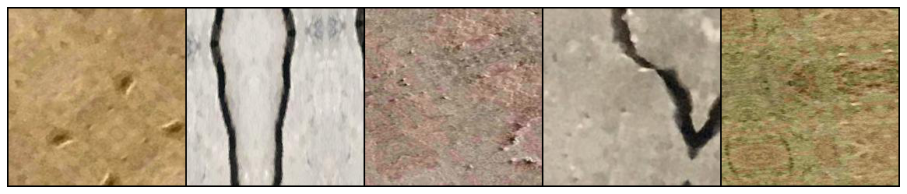

In [ ]:
# check labels in augmented images (using batch size of 5 in dataloader)
'''
Label 0 = no surface crack
Label 1 = has surface crack
'''

print('aug_images.shape:', aug_images.shape)
plt.figure(figsize=(16,8))
plt.axis('off')
plt.imshow(make_grid(aug_images, nrow=5).permute((1, 2, 0)))
    
print(f'Labels: {aug_labels}')

# Construct model
Yann LeCun's LeNet5 architecture: https://towardsdatascience.com/implementing-yann-lecuns-lenet-5-in-pytorch-5e05a0911320

In [5]:
class LeNet5(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # convolutional layers
        self.conv1 = nn.Conv2d(3, 6, 5, padding=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=2, stride=2)       
        self.conv3 = nn.Conv2d(16, 120, 5, padding=2, stride=2)

        # fully connected layers
        self.fc1 = nn.Linear(120*49, 84)
        self.fc2 = nn.Linear(84, 2)   # have two classes (has crack/no crack)
        
        # softmax layer
        self.softmax = nn.Softmax(dim=1)
        
        # pooling layer
        self.pool = nn.AvgPool2d(kernel_size=2)  # Average pool 2x2

    def forward(self,x):

        x = F.tanh(self.conv1(x)) # layer 1
        x = self.pool(x)          # layer 2
        
        x = F.tanh(self.conv2(x)) # layer 3
        x = self.pool(x)          # layer 4
        
        x = F.tanh(self.conv3(x)) # layer 5
        
        x = torch.flatten(x, 1)   # flatten
        
        x = F.tanh(self.fc1(x))   # reshape layer
        logit = self.fc2(x)       # layer 6
        
        output = self.softmax(logit) # layer 7

        return logit, output

In [6]:
# print model summary

model = LeNet5()

channels = 3
H = 227
W = 227

summary(model, (channels, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 114, 114]             456
         AvgPool2d-2            [-1, 6, 57, 57]               0
            Conv2d-3           [-1, 16, 29, 29]           2,416
         AvgPool2d-4           [-1, 16, 14, 14]               0
            Conv2d-5            [-1, 120, 7, 7]          48,120
            Linear-6                   [-1, 84]         494,004
            Linear-7                    [-1, 2]             170
           Softmax-8                    [-1, 2]               0
Total params: 545,166
Trainable params: 545,166
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.59
Forward/backward pass size (MB): 0.92
Params size (MB): 2.08
Estimated Total Size (MB): 3.59
----------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


### Find optimal learning rate

**Train model with learning rates by starting with small number of batches**, so can confirm that architecture is okay.

In [7]:
# for timing model training purposes
start_time = time.time()

# input variables
epoch_num = 6
learning_rate = 0.1

# train model
model = LeNet5()
cost_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# to store loss for training & validation set
jw_train_epoch = []  ## to store loss for training set by epoch (average loss of iterations)
jw_val_epoch = []    ## to store loss for validation set by epoch (average loss of iterations)

# to store accuracy of training & validation set
acc_train_epoch = []
acc_val_epoch = []

for epoch in range(epoch_num):

    # track train & validation loss & accuracy by iteration for each epoch
    train_loss = []
    train_acc = []

    val_loss = []
    val_acc = []

    test_counter = 1

    for i, data in enumerate(dataloader, 0):

        ''' include below IF statement if want to limit number of batches '''
        if i+1 == 501:  # should have total of 500 batches after train & val sets
            break
        
        # use 80% for training, 20% for testing, and 10% for validation of the 40k training samples
        ## batch size=64 so 625 batches total: 450 train batches, 50 val batches, and 125 test batches

        if i+1 > 450:  # validate model with validation set (10% of total train data)
            inputs, labels = data
            
            logits, outputs = model(inputs)
            cost = cost_fn(logits, labels)
            
            jw_val = float(cost)

            # calculate accuracy
            pred = torch.Tensor.argmax(outputs, dim=1)
            correct = pred == labels
            acc = sum(np.array(correct))/len(np.array(correct))

            acc_val = acc

            val_loss.append(jw_val)
            val_acc.append(acc_val)
            
            print(f'Validation iteration {i+1} loss: {jw_val}, ACC: {acc_val}')
            
        else:  # train model with training set

            inputs, labels = data

            optimizer.zero_grad()            # zero the parameter gradients
            logits, outputs = model(inputs)  # forward
            cost = cost_fn(logits, labels)   # input logits prior to softmax activation into cost function
            cost.backward()                  # backward
            optimizer.step()                 # optimize

            jw_train = float(cost)

            # calculate accuracy
            pred = torch.Tensor.argmax(outputs, dim=1)            # get labels of prediction with highest probability
            correct = pred == labels                              # compare to actual labels and see which was predicted correctly

            acc = sum(np.array(correct))/len(np.array(correct))   # calculate accuracy

            acc_train = acc

            train_loss.append(jw_train)
            train_acc.append(acc_train)
            
            print(f'Training iteration {i+1} loss: {jw_train}, ACC:{acc_train}')

    # to save time, epoch loss = the lowest loss, epoch acc = highest acc in training
    epoch_jw = np.mean(np.array(train_loss))
    epoch_acc = np.mean(np.array(train_acc))

    jw_train_epoch.append(epoch_jw)
    jw_val_epoch.append(np.mean(val_loss))
    acc_train_epoch.append(epoch_acc)
    acc_val_epoch.append(np.mean(val_acc))
    
    print(f'-- Epoch {epoch+1} done -- Train loss: {epoch_jw}, train ACC: {epoch_acc}, val loss: {np.mean(val_loss)}, val ACC: {np.mean(val_acc)}')
    
    print("<--- %s seconds --->" % (time.time() - start_time))

    # save model at every epoch
    path = f"/content/drive/MyDrive/SJSU MSDA/Fall 2021/DATA 255/Project/Code/LeNet5_model_saves/00_tanh_lr0.1/lenet5_lr0.1_cpu_epoch{epoch+1}.pth"
    torch.save(model.state_dict(), path)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Training iteration 1 loss: 0.6936317086219788, ACC:0.5
Training iteration 2 loss: 3.4028635025024414, ACC:0.578125
Training iteration 3 loss: 1.9545999765396118, ACC:0.515625
Training iteration 4 loss: 1.8310450315475464, ACC:0.453125
Training iteration 5 loss: 1.8549911975860596, ACC:0.515625
Training iteration 6 loss: 3.036938428878784, ACC:0.375
Training iteration 7 loss: 0.6755508184432983, ACC:0.59375
Training iteration 8 loss: 1.5699164867401123, ACC:0.5625
Training iteration 9 loss: 1.6375796794891357, ACC:0.578125
Training iteration 10 loss: 1.0434997081756592, ACC:0.421875
Training iteration 11 loss: 1.5625298023223877, ACC:0.5
Training iteration 12 loss: 2.2749226093292236, ACC:0.453125
Training iteration 13 loss: 1.1759434938430786, ACC:0.5
Training iteration 14 loss: 0.9440804123878479, ACC:0.546875
Training iteration 15 loss: 1.6352301836013794, ACC:0.546875
Training iteration 16 loss: 1.396681308746338, ACC:0.546875
Training iteration 17 loss: 0.7184805870056152, ACC:0.5


Plot loss and accuracy over epochs

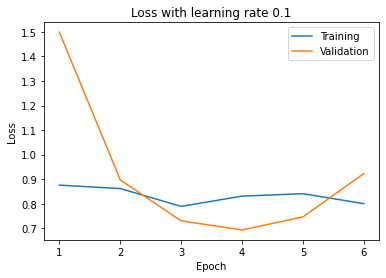

In [8]:
# plot loss over epoch
plt.plot([i+1 for i in range(len(jw_train_epoch))],jw_train_epoch)
plt.plot([i+1 for i in range(len(jw_val_epoch))],jw_val_epoch)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss with learning rate {learning_rate}')
plt.legend(['Training','Validation'])
plt.show()

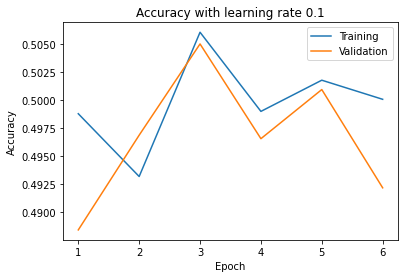

In [9]:
# plot accuracy over epoch
plt.plot([i+1 for i in range(len(acc_train_epoch))],acc_train_epoch)
plt.plot([i+1 for i in range(len(acc_val_epoch))],acc_val_epoch)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy with learning rate {learning_rate}')
plt.legend(['Training','Validation'])
plt.show()

**Calculate test accuracy for model**

In [10]:
# load saved model 
path = f"/content/drive/MyDrive/SJSU MSDA/Fall 2021/DATA 255/Project/Code/LeNet5_model_saves/00_tanh_lr0.1/lenet5_lr0.1_cpu_epoch{3}.pth"

model = LeNet5()
model.load_state_dict(torch.load(path))
print(model.eval())

# or use model in current session
# model = model

# calculate test accuracy of model at a given epoch

testset_path = f"/content/drive/MyDrive/SJSU MSDA/Fall 2021/DATA 255/Project/Code/LeNet5_model_saves/00_tanh_lr0.001/lenet5_lr0.001_testset.pth"
inputs, labels = torch.load(testset_path)

logits, outputs = model(inputs)

# calculate overall accuracy across all classes
pred = torch.Tensor.argmax(outputs, dim=1)
correct = pred == labels

correct_cnt = sum(np.array(correct))
data_cnt = len(np.array(correct))

print(f'\n Testing accuracy = {(correct_cnt/data_cnt)*100:.1f}%')

LeNet5(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (fc1): Linear(in_features=5880, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



 Testing accuracy = 50.2%
